<a href="https://colab.research.google.com/github/vannguyenhoai43-hash/ecommerce-category-growth-analysis/blob/main/notebooks/03_growth_driver_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**PHẦN 3: PHÂN TÍCH ĐỘNG LỰC TĂNG TRƯỞNG**

Mục tiêu của phần này là xác định những ngành hàng Level 2 và nhóm sản phẩm chính đang đóng góp vào sự thay đổi tăng/giảm của toàn ngành theo tháng.

**Bước 1: Xác định danh mục Level 2 đóng góp chính**

- Tính mức tăng trưởng tuyệt đối (diff_ado/gmv) của từng Level 2

- Tính % đóng góp (contrib_ado/gmv) của từng Level 2 vào tổng mức tăng trưởng

- Xác định:

  - Top 3 Level 2 tăng mạnh nhất

  - Top 3 Level 2 suy giảm nhiều nhất

**Mục tiêu:** xác định đâu là nhóm ngành hàng đang kéo giảm hiệu suất chung.

**Bước 2: Phân tích sâu theo nhóm sản phẩm nổi bật**

Sau khi xác định các Level 2 ở trên , tiến hành phân tích ở cấp độ sản phẩm (đã được chuẩn hóa và nhóm theo keywords):

- Đối với Level 2 tăng trưởng mạnh:

  - Top down các sản phẩm có mức diff_ado/gmv cao nhất, lấy top 3 sản phẩm.

- Đối với Level 2 suy giảm hoặc tăng trưởng chậm:

  - Tập trung vào các sản phẩm ADO/GMV tháng trước cao nhưng giảm mạnh ở tháng này: lấy top 20 sản phẩm có mức ADO/GMV cao nhất ở tháng trước , rồi lấy top 3 diff_ado/gmv từ thấp tới cao.

**Mục tiêu:** làm rõ tăng trưởng/ suy giảm đến từ nhóm sản phẩm nào.

### Import data:

In [2]:
!git clone -q https://github.com/vannguyenhoai43-hash/ecommerce-category-growth-analysis.git

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.append("/content/ecommerce-category-growth-analysis/src")

from load_data import load_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# DF theo level 2 với cur_month = 20024-09
df_cur_lv2= load_data(month='2024-09')['cur_lv2']

In [6]:
# DF theo items với cur_month = 20024-09
df_cur_items= load_data(month='2024-09')['cur_items']

## Triển khai

In [8]:
#  Tính Tăng trưởng theo level 1 + level 2
from metrics import growth_by_mul_level
l1_L2_growth = growth_by_mul_level(df_cur_lv2, ['level2_kpi_category', 'level1_kpi_category'])
l1_L2_growth_sort = l1_L2_growth.sort_values('level1_kpi_category')
l1_L2_growth_sort.head()

,diff_ado,diff_gmv,grow_ado,grow_gmv,ADO_M,ADO_M_1,AdGMV_M,AdGMV_M_1,level2_kpi_category,level1_kpi_category
0,290.342090,3716.924910,0.234386,0.311089,1529.075623,1238.733533,15665.037605,11948.112695,Construction Materials,Home & Technical Supplies
1,-24.213226,1050.865811,-0.009547,0.078658,2512.021190,2536.234416,14410.881609,13360.015798,Electrical Components,Home & Technical Supplies
2,-159.927383,1376.460112,-0.039813,0.041144,3857.005408,4016.932791,34831.208751,33454.748639,Heavy-duty Equipment,Home & Technical Supplies
13,500.957482,2415.399676,0.174388,0.183774,3373.615984,2872.658502,15558.736710,13143.337034,Support Supplies,Home & Technical Supplies
5,-11.312137,3672.836328,-0.003345,0.174806,3370.196077,3381.508214,24683.793652,21010.957324,Manual Tools,Home & Technical Supplies


In [9]:
# Chuyển item_name về các nhóm keywords
from metrics import clean_and_shorten
item_df = df_cur_items.copy()
item_df ['keywords']= item_df ['item_name'].apply(clean_and_shorten)

In [10]:
# Tính % đóng góp tăng trưởng
df_contrib= l1_L2_growth_sort.copy()
# Theo ADO
df_contrib['total_ado_growth'] = df_contrib.groupby('level1_kpi_category')['diff_ado'].transform('sum')
df_contrib['contrib_ado'] = df_contrib['diff_ado']/df_contrib['total_ado_growth']
# Theo GMV
df_contrib['total_gmv_growth'] = df_contrib.groupby('level1_kpi_category')['diff_gmv'].transform('sum')
df_contrib['contrib_gmv'] = df_contrib['diff_ado']/df_contrib['total_gmv_growth']

### Tăng trưởng

####Theo ngành hàng

In [11]:
# Top ngành hàng level 2 có mức tăng trưởng tốt (top 3 diff_ado>0)
highest_ado_contrib = (df_contrib
                  .query("diff_ado > 0")
                  .sort_values(by=['level1_kpi_category','diff_ado'],ascending=[True,False])
                  .groupby('level1_kpi_category')
                  .head(3)
                  [['level1_kpi_category','level2_kpi_category', 'diff_ado','contrib_ado']]
)
highest_ado_contrib

,level1_kpi_category,level2_kpi_category,diff_ado,contrib_ado
13,Home & Technical Supplies,Support Supplies,500.957482,0.878646
0,Home & Technical Supplies,Construction Materials,290.342090,0.509241
11,Vehicle Essentials,Safety Gear,410.234619,0.477563
3,Vehicle Essentials,In-car Utilities,359.185292,0.418135
15,Vehicle Essentials,Vehicle Add-ons,290.833185,0.338565


In [12]:
# Top ngành hàng level 2 có mức tăng trưởng tốt (top 3 diff_gmv >0)
highest_gmv_contrib = (df_contrib
                  .query("diff_gmv > 0")
                  .sort_values(by=['level1_kpi_category','diff_gmv'],ascending=[True,False])
                  .groupby('level1_kpi_category')
                  .head(3)
                  [['level1_kpi_category','level2_kpi_category', 'diff_gmv','contrib_gmv']]
)
highest_gmv_contrib

,level1_kpi_category,level2_kpi_category,diff_gmv,contrib_gmv
0,Home & Technical Supplies,Construction Materials,3716.924910,0.024263
5,Home & Technical Supplies,Manual Tools,3672.836328,-0.000945
13,Home & Technical Supplies,Support Supplies,2415.399676,0.041863
8,Vehicle Essentials,Personal Mobility,5077.185056,0.002557
3,Vehicle Essentials,In-car Utilities,3088.709561,0.095552
15,Vehicle Essentials,Vehicle Add-ons,2088.187566,0.077369


####Theo sản phẩm

In [14]:
# tăng trưởng theo level 1 + level 2 + items
item_growth = growth_by_mul_level(item_df, ['level1_kpi_category','level2_kpi_category','keywords'])
item_growth_sort = item_growth.sort_values('level1_kpi_category')
item_growth_sort.head()

,diff_ado,diff_gmv,grow_ado,grow_gmv,ADO_M,ADO_M_1,AdGMV_M,AdGMV_M_1,level1_kpi_category,level2_kpi_category,keywords
0,-0.160592,-0.707066,-0.178649,-0.241408,0.738333,0.898925,2.221864,2.928930,Home & Technical Supplies,Construction Materials,0 5kg bột trét gỗ
20878,1.837500,9.015158,0.000000,0.000000,1.837500,0.000000,9.015158,0.000000,Home & Technical Supplies,Manual Tools,coil hút van điện từ
20877,0.079659,0.651088,12.346404,34.011806,0.086111,0.006452,0.670231,0.019143,Home & Technical Supplies,Manual Tools,co điếu inox 304 ren
20876,0.028725,-0.039050,6.233724,-0.514391,0.033333,0.004608,0.036865,0.075915,Home & Technical Supplies,Manual Tools,co tê lơi ống 27
20875,0.512414,1.237088,22.165153,3.407778,0.535532,0.023118,1.600107,0.363019,Home & Technical Supplies,Manual Tools,co nhựa pvc thành


In [15]:
#Lọc top ado level 2
level2_top_ado_list = (
    highest_ado_contrib
    .loc[highest_ado_contrib['level2_kpi_category'] != 'Others',
         'level2_kpi_category']
    .unique()
    .tolist()
)

level2_top_ado_list

['Support Supplies',
 'Construction Materials',
 'Safety Gear',
 'In-car Utilities',
 'Vehicle Add-ons']

In [16]:
#Lọc top gmv level 2
level2_top_gmv_list = (
    highest_gmv_contrib
    .loc[highest_gmv_contrib['level2_kpi_category'] != 'Others',
         'level2_kpi_category']
    .unique()
    .tolist()
)

level2_top_gmv_list

['Construction Materials',
 'Manual Tools',
 'Support Supplies',
 'Personal Mobility',
 'In-car Utilities',
 'Vehicle Add-ons']

In [17]:
#Theo ADO
#Danh sách các ngành hàng là top level 2
df_ado_l1_l2_item = item_growth[
    item_growth['level2_kpi_category'].isin(level2_top_ado_list)
].copy()

In [18]:
#Theo GMV
#Danh sách các ngành hàng là top level 2
df_gmv_l1_l2_item = item_growth[
    item_growth['level2_kpi_category'].isin(level2_top_gmv_list)
].copy()

In [20]:
# Theo ADO
# Danh sách top 3 sản phẩm theo cat có mức tăng trưởng tốt
from metrics import top3_items
top3_items_ado =  top3_items(df_ado_l1_l2_item,'ado')
top3_items_ado_sort = top3_items_ado.sort_values(['level1_kpi_category','level2_kpi_category'],ascending = [True,True])
top3_items_ado_sort

,level1_kpi_category,level2_kpi_category,keywords,diff_ado
1687,Home & Technical Supplies,Construction Materials,xi măng dẻo bịt lỗ,115.172424
992,Home & Technical Supplies,Construction Materials,sàn nhựa giả gỗ sẵn,61.499444
993,Home & Technical Supplies,Construction Materials,sàn nhựa giả vân gỗ,21.716667
28244,Home & Technical Supplies,Support Supplies,bộ sạc 4 pin aa,86.113333
28030,Home & Technical Supplies,Support Supplies,băng keo điện nano dai,68.438889
28894,Home & Technical Supplies,Support Supplies,keo dính đa năng mạnh,60.534828
35046,Vehicle Essentials,In-car Utilities,đỡ điện thoại ô tô,36.141760
31492,Vehicle Essentials,In-car Utilities,bảng số điện thoại ô,31.693965
34048,Vehicle Essentials,In-car Utilities,thảm lót sàn cao su,22.324274
65850,Vehicle Essentials,Safety Gear,mũ bảo hiểm nửa đầu,236.231997


In [21]:
# Theo GMV
# Danh sách top 3 gmv theo cat có mức tăng trưởng tốt
from metrics import top3_items
top3_items_gmv =  top3_items(df_gmv_l1_l2_item,'gmv')
top3_items_gmv_sort = top3_items_gmv.sort_values(['level1_kpi_category','level2_kpi_category'],ascending = [True,True])
top3_items_gmv_sort

,level1_kpi_category,level2_kpi_category,keywords,diff_gmv
992,Home & Technical Supplies,Construction Materials,sàn nhựa giả gỗ sẵn,878.863229
993,Home & Technical Supplies,Construction Materials,sàn nhựa giả vân gỗ,365.989754
480,Home & Technical Supplies,Construction Materials,combo 1 36 sàn nhựa,283.121069
23347,Home & Technical Supplies,Manual Tools,máy khoan đục bê tông,343.459833
23453,Home & Technical Supplies,Manual Tools,máy siết bulong pin drama,245.156173
23396,Home & Technical Supplies,Manual Tools,máy siết bulong de walt,218.340548
28244,Home & Technical Supplies,Support Supplies,bộ sạc 4 pin aa,671.295274
29599,Home & Technical Supplies,Support Supplies,năng lượng mặt trời mono,279.782734
28415,Home & Technical Supplies,Support Supplies,combo 100 keo nến dài,181.901582
34068,Vehicle Essentials,In-car Utilities,thảm lót sàn ô tô,1407.725238


### Suy giảm

#### Theo ngành hàng

In [22]:
# Theo ADO
df_lowest_l2_ado = (df_contrib
                  .query("diff_ado < 0")
                  .sort_values(by=['level1_kpi_category','diff_ado'],ascending=[True,True])
                  .groupby('level1_kpi_category')
                  .head(3)
                  [['level1_kpi_category','level2_kpi_category', 'diff_ado','contrib_ado']]
)
df_lowest_l2_ado

,level1_kpi_category,level2_kpi_category,diff_ado,contrib_ado
2,Home & Technical Supplies,Heavy-duty Equipment,-159.927383,-0.280502
12,Home & Technical Supplies,Safety Solutions,-25.699967,-0.045076
1,Home & Technical Supplies,Electrical Components,-24.213226,-0.042468
10,Vehicle Essentials,Riding Accessories,-278.323065,-0.324002
9,Vehicle Essentials,Repair Components,-217.429876,-0.253115
4,Vehicle Essentials,Maintenance Fluids,-92.698572,-0.107912


In [23]:
# Theo GMV
df_lowest_l2_gmv = (df_contrib
                  .query("diff_gmv < 0")
                  .sort_values(by=['level1_kpi_category','diff_gmv'],ascending=[True,True])
                  .groupby('level1_kpi_category')
                  .head(3)
                  [['level1_kpi_category','level2_kpi_category', 'diff_gmv','contrib_gmv']]
)
df_lowest_l2_gmv

,level1_kpi_category,level2_kpi_category,diff_gmv,contrib_gmv
12,Home & Technical Supplies,Safety Solutions,-265.984952,-0.002148
10,Vehicle Essentials,Riding Accessories,-3071.923313,-0.074041
9,Vehicle Essentials,Repair Components,-2871.259945,-0.057842
4,Vehicle Essentials,Maintenance Fluids,-1305.599699,-0.024660


In [24]:
# Theo ADO
# Danh sách ngành hàng level 2 mức giảm nhiều nhất
low_grow_ado_cat = df_lowest_l2_ado['level2_kpi_category'].unique()
low_grow_ado_cat

array(['Heavy-duty Equipment', 'Safety Solutions',
       'Electrical Components', 'Riding Accessories', 'Repair Components',
       'Maintenance Fluids'], dtype=object)

In [25]:
#Theo GMV
# Danh sách ngành hàng level 2 mức giảm nhiều nhất
low_grow_gmv_cat = df_lowest_l2_gmv['level2_kpi_category'].unique()
low_grow_gmv_cat

array(['Safety Solutions', 'Riding Accessories', 'Repair Components',
       'Maintenance Fluids'], dtype=object)

#### Theo sản phẩm

In [26]:
# Danh sách sản phẩm theo cat có mức giảm nhiều nhất theo ADO
df_low_ado_items = item_growth[
    item_growth['level2_kpi_category'].isin(low_grow_ado_cat)
].copy()

In [27]:
# Danh sách sản phẩm theo cat có mức giảm nhiều nhất theo GMV
df_low_gmv_items = item_growth[
    item_growth['level2_kpi_category'].isin(low_grow_gmv_cat)
].copy()

In [28]:
#Theo ADO
# Danh sách top 3 sản phẩm theo cat có mức giảm nhiều nhất (top 20 ADO_M_1 và top 3 diff_ADO giảm nhiều nhất)
from metrics import top3_items_low
top3_items_low_ado =  top3_items_low(df_low_gmv_items,'ado')
top3_items_low_ado

,level1_kpi_category,level2_kpi_category,keywords,ADO_M,ADO_M_1,diff_ado
27337,Home & Technical Supplies,Safety Solutions,ổ khoá tay nắm tròn,33.749558,36.322379,-2.572821
27357,Home & Technical Supplies,Safety Solutions,ổ khóa bấm việt nhật,3.872222,6.314516,-2.442294
27129,Home & Technical Supplies,Safety Solutions,khóa chống cắt zsolex,1.015132,2.806748,-1.791616
55421,Vehicle Essentials,Repair Components,đèn led xi nhan lùi,1.693096,65.887423,-64.194327
57838,Vehicle Essentials,Riding Accessories,bao tay daytona gù salaya,8.856376,58.182963,-49.326587
57676,Vehicle Essentials,Riding Accessories,7 titan cực đẹp gắn,0.429999,47.061074,-46.631075
61495,Vehicle Essentials,Riding Accessories,kẹp điện thoại lên đồng,0.097222,45.501920,-45.404698
52652,Vehicle Essentials,Repair Components,tay nắm kiểu sh mode,5.624444,43.049768,-37.425324
44803,Vehicle Essentials,Repair Components,cùm tăng tốc domino bao,1.435834,37.627857,-36.192023
35579,Vehicle Essentials,Maintenance Fluids,mỡ tra bảo dưỡng xe,16.416339,28.637941,-12.221602


In [29]:
#Theo GMV
# Danh sách top 3 sản phẩm theo cat có mức giảm nhiều nhất (top 20 GMV_M_1 và top 3 diff_GMV giảm nhiều nhất)
from metrics import top3_items_low
top3_items_low_gmv =  top3_items_low(df_low_gmv_items,'gmv')
top3_items_low_gmv

,level1_kpi_category,level2_kpi_category,keywords,AdGMV_M,AdGMV_M_1,diff_gmv
27236,Home & Technical Supplies,Safety Solutions,két sắt điện tử xiaomi,55.897910,104.648486,-48.750576
27004,Home & Technical Supplies,Safety Solutions,combo 2 cháy bột abc,12.780541,48.072587,-35.292046
27003,Home & Technical Supplies,Safety Solutions,combo 2 cháy 4kg cứu,240.572160,270.104531,-29.532371
64782,Vehicle Essentials,Riding Accessories,động cơ qs 3kv4 và,472.424557,896.054256,-423.629699
51431,Vehicle Essentials,Repair Components,pô exciter 2010 êm cổ,34.894738,291.773256,-256.878518
52455,Vehicle Essentials,Repair Components,sạc ắc quy 6ah 150ah,0.631246,203.244219,-202.612973
56629,Vehicle Essentials,Repair Components,động cơ 5000w v4 12,119.888941,297.269863,-177.380922
57987,Vehicle Essentials,Riding Accessories,bi led 3 0 e11,1.332288,139.470992,-138.138704
62817,Vehicle Essentials,Riding Accessories,tay xách wave 50 100,6.387575,129.393413,-123.005838
35579,Vehicle Essentials,Maintenance Fluids,mỡ tra bảo dưỡng xe,36.637142,65.880033,-29.242891


In [30]:
df_home_tech = l1_L2_growth[l1_L2_growth['level1_kpi_category'] == 'Home & Technical Supplies']
df_vehicle = l1_L2_growth[l1_L2_growth['level1_kpi_category'] == 'Vehicle Essentials']

## Kết quả

## PHÂN TÍCH ĐỘNG LỰC TĂNG TRƯỞNG

## Các ngành hàng đóng góp tăng trưởng chính

**Về Vehicle Essentials**
 
- **ADO**: Tăng trưởng chủ yếu đến từ các ngành hàng  **Safety Gear, In-car Utilities, Vehicle Add-ons**, đóng góp 123.4% tổng mức tăng. Một số sản phẩm tiêu biểu như: 
 

 
  - **Safety Gear**: **mũ bảo hiểm nửa đầu** (+236.23 ADO), **mũ bảo hiểm lưỡi trai** (+124.08 ADO), **mũ bảo hiểm đai da** (+92.93 ADO)
 
  - **In-car Utilities**: **đỡ điện thoại ô tô** (+36.14 ADO), **bảng số điện thoại ô** (+31.69 ADO), **thảm lót sàn cao su** (+22.32 ADO)
 
  - **Vehicle Add-ons**: **combo 4 nắp van bánh** (+23.31 ADO), **nẹp decal bậc xe ô** (+22.23 ADO), **bộ khung biển số mica** (+20.87 ADO)
 

- **GMV**: Tăng trưởng chủ yếu đến từ nhóm (**Personal Mobility, In-car Utilities, Vehicle Add-ons**), đóng góp 17.5% tổng mức tăng. Một số sản phẩm tiêu biểu như:
 

 
  - **In-car Utilities**: **thảm lót sàn ô tô** (+1407.73 GMV), **màn hình android ô tô** (+930.21 GMV), **thảm lót sàn cao su** (+376.56 GMV)
 
  - **Personal Mobility**: **xe đạp điện học sinh** (+1328.61 GMV), **xe đạp điện moka niceshine** (+795.04 GMV), **xe điện 3 bánh super** (+684.49 GMV)
 
  - **Vehicle Add-ons**: **quây chống chuột xe ô** (+491.23 GMV), **quây chống chuột rào chắn** (+173.45 GMV), **bạt phủ ô tô xe** (+123.68 GMV)

**Về Home & Technical Supplies**
 
- **ADO**: Tăng trưởng chủ yếu đến từ các ngành hàng  **Support Supplies, Construction Materials**, đóng góp 138.8% tổng mức tăng. Một số sản phẩm tiêu biểu như: 
 

 
  - **Construction Materials**: **xi măng dẻo bịt lỗ** (+115.17 ADO), **sàn nhựa giả gỗ sẵn** (+61.50 ADO), **sàn nhựa giả vân gỗ** (+21.72 ADO)
 
  - **Support Supplies**: **bộ sạc 4 pin aa** (+86.11 ADO), **băng keo điện nano dai** (+68.44 ADO), **keo dính đa năng mạnh** (+60.53 ADO)
 

- **GMV**: Tăng trưởng chủ yếu đến từ nhóm (**Construction Materials, Manual Tools, Support Supplies**), đóng góp 6.5% tổng mức tăng. Một số sản phẩm tiêu biểu như:
 

 
  - **Construction Materials**: **sàn nhựa giả gỗ sẵn** (+878.86 GMV), **sàn nhựa giả vân gỗ** (+365.99 GMV), **combo 1 36 sàn nhựa** (+283.12 GMV)
 
  - **Support Supplies**: **bộ sạc 4 pin aa** (+671.30 GMV), **năng lượng mặt trời mono** (+279.78 GMV), **combo 100 keo nến dài** (+181.90 GMV)
 
  - **Manual Tools**: **máy khoan đục bê tông** (+343.46 GMV), **máy siết bulong pin drama** (+245.16 GMV), **máy siết bulong de walt** (+218.34 GMV)

## Các ngành hàng suy giảm

**Về Vehicle Essentials**
 
- **ADO**: Ngành hàng tăng trưởng chậm/ giảm gồm: **Riding Accessories, Repair Components, Maintenance Fluids**, chiếm -68.5% tổng mức biến động. Một số sản phẩm giảm ADO đáng chú ý như: 
 

 
  - **Repair Components**: **cùm tăng tốc domino bao** (-36.19 ADO), **tay nắm kiểu sh mode** (-37.43 ADO), **đèn led xi nhan lùi** (-64.19 ADO).
 
  - **Riding Accessories**: **kẹp điện thoại lên đồng** (-45.40 ADO), **7 titan cực đẹp gắn** (-46.63 ADO), **bao tay daytona gù salaya** (-49.33 ADO).
 
  - **Maintenance Fluids**: **mỡ bò bảo dưỡng sên** (-2.94 ADO), **vệ sinh sên xích bảo** (-3.45 ADO), **mỡ tra bảo dưỡng xe** (-12.22 ADO).
 

- **GMV**: Ngành hàng tăng trưởng chậm/ giảm gồm: (**Riding Accessories, Repair Components, Maintenance Fluids**), chiếm -15.7% tổng mức biến động. Một số sản phẩm giảm GMV đáng chú ý như: 
 

 
  - **Riding Accessories**: **tay xách wave 50 100** (-123.01 GMV), **bi led 3 0 e11** (-138.14 GMV), **động cơ qs 3kv4 và** (-423.63 GMV).
 
  - **Repair Components**: **động cơ 5000w v4 12** (-177.38 GMV), **sạc ắc quy 6ah 150ah** (-202.61 GMV), **pô exciter 2010 êm cổ** (-256.88 GMV).
 
  - **Maintenance Fluids**: **1 12 nhớt tổng hợp** (-17.74 GMV), **combo nhớt máy láp shell** (-21.39 GMV), **mỡ tra bảo dưỡng xe** (-29.24 GMV).

**Về Home & Technical Supplies**
 
- **ADO**: Ngành hàng tăng trưởng chậm/ giảm gồm: **Heavy-duty Equipment, Safety Solutions, Electrical Components**, chiếm -36.8% tổng mức biến động. Một số sản phẩm giảm ADO đáng chú ý như: 
 

 
  - **Safety Solutions**: **khóa chống cắt zsolex** (-1.79 ADO), **ổ khóa bấm việt nhật** (-2.44 ADO), **ổ khoá tay nắm tròn** (-2.57 ADO).
 

- **GMV**: Ngành hàng tăng trưởng chậm/ giảm gồm: (**Safety Solutions**), chiếm -0.2% tổng mức biến động. Một số sản phẩm giảm GMV đáng chú ý như: 
 

 
  - **Safety Solutions**: **combo 2 cháy 4kg cứu** (-29.53 GMV), **combo 2 cháy bột abc** (-35.29 GMV), **két sắt điện tử xiaomi** (-48.75 GMV).

## Trực quan bằng biểu đồ 



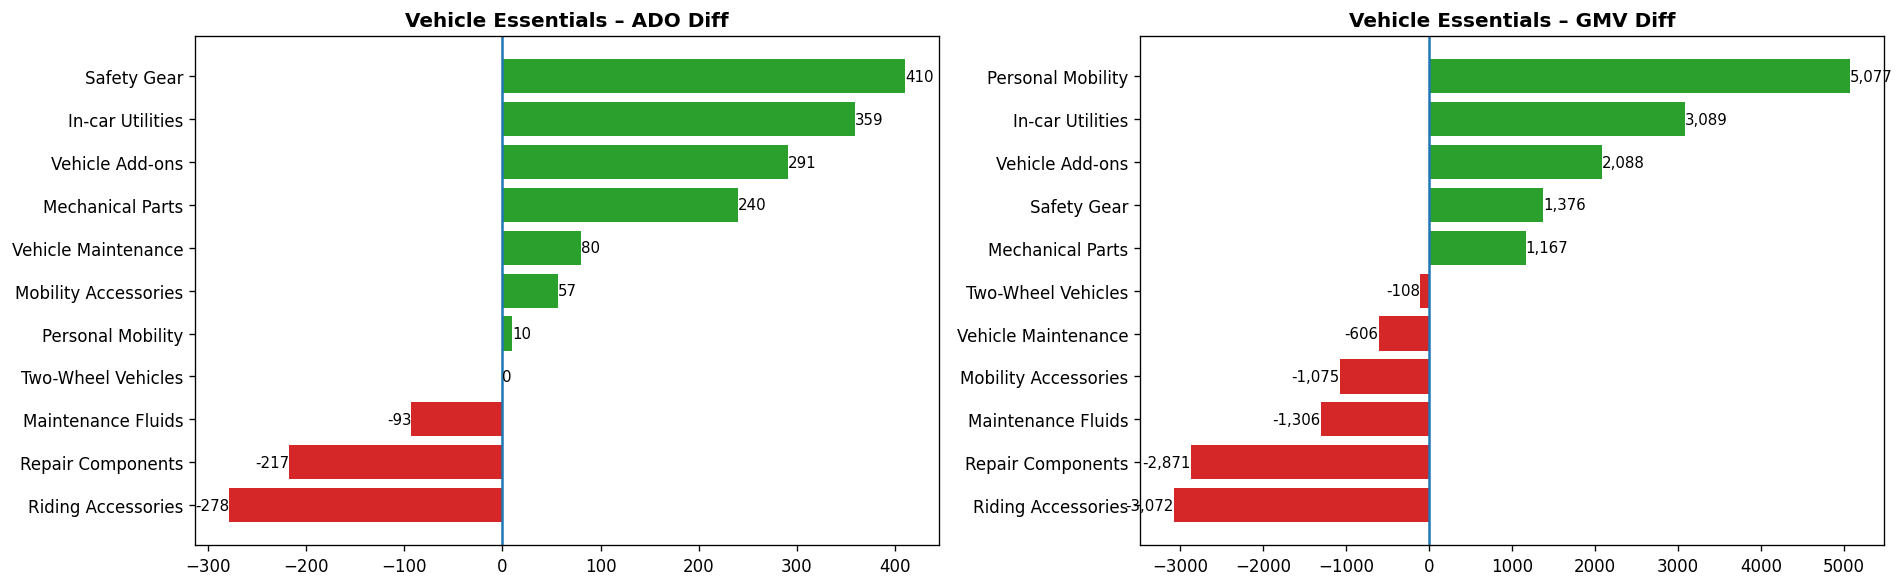

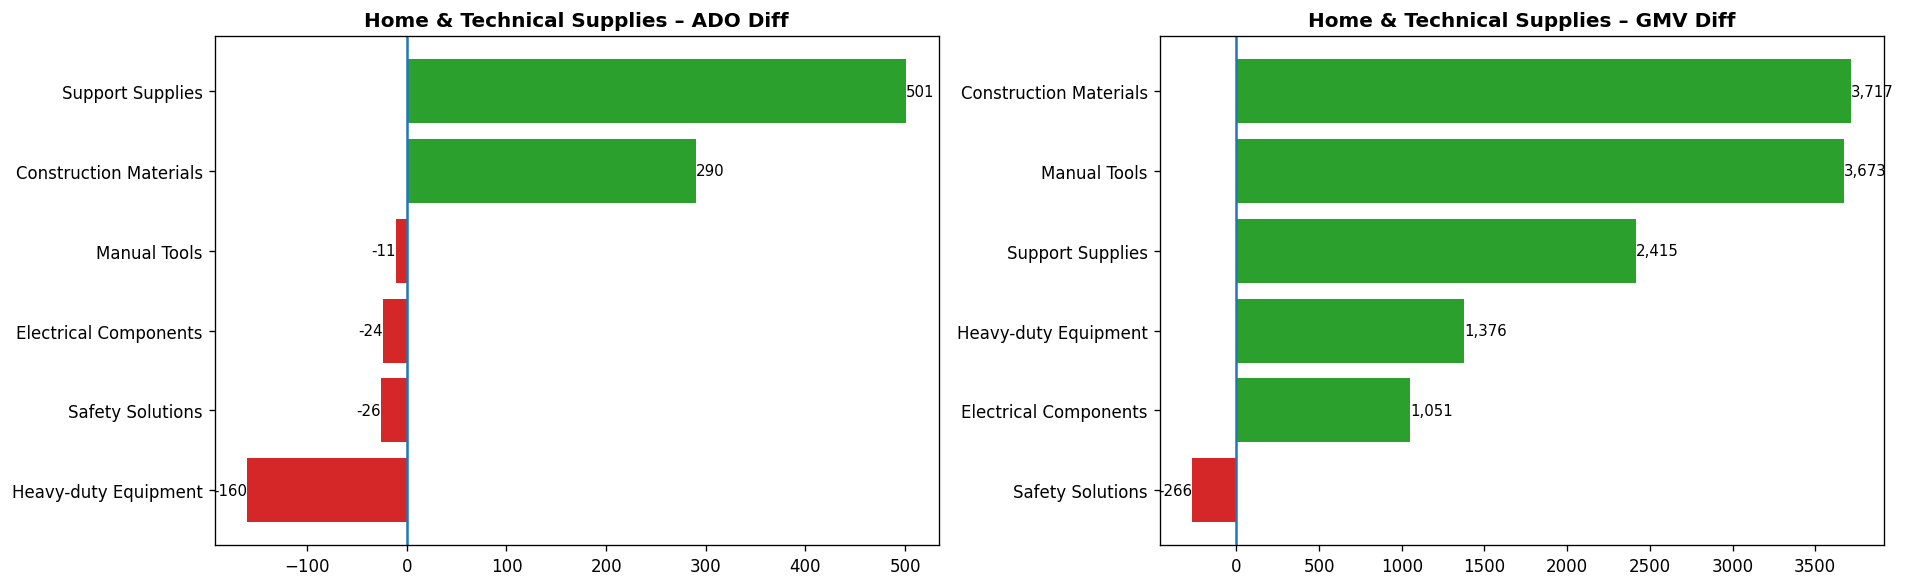

In [38]:
from IPython.core.interactiveshell import dis
from IPython.display import Markdown, display
from metrics import insight_ado_gmv_from_items
from metrics import insight_low_ado_gmv_items
from charts import plot_cat

display(Markdown("## PHÂN TÍCH ĐỘNG LỰC TĂNG TRƯỞNG"))
display(Markdown("## Các ngành hàng đóng góp tăng trưởng chính"))
# Cat tăng
# Tăng trưởng Vehicle Essentials
insight_text_1 = insight_ado_gmv_from_items(
            contrib_ado_df= highest_ado_contrib,
            contrib_gmv_df= highest_gmv_contrib,
            df_ado= top3_items_ado,
            df_gmv = top3_items_gmv,
            lvl1='Vehicle Essentials'
    )
display(Markdown(insight_text_1))

# Tăng trưởng Home & Technical Supplies
insight_text_2 = insight_ado_gmv_from_items(
            contrib_ado_df= highest_ado_contrib,
            contrib_gmv_df= highest_gmv_contrib,
            df_ado= top3_items_ado,
            df_gmv = top3_items_gmv,
            lvl1='Home & Technical Supplies'
    )
display(Markdown(insight_text_2))

display(Markdown("## Các ngành hàng suy giảm"))
# Cat giảm
insight_text_3= insight_low_ado_gmv_items(
                                          contrib_ado_df= df_lowest_l2_ado,
                                          contrib_gmv_df= df_lowest_l2_gmv,
                                          df_ado= top3_items_low_ado,
                                          df_gmv = top3_items_low_gmv,
                                          lvl1="Vehicle Essentials"
                                        )

display(Markdown(insight_text_3))

insight_text_4= insight_low_ado_gmv_items(
                                          contrib_ado_df= df_lowest_l2_ado,
                                          contrib_gmv_df= df_lowest_l2_gmv,
                                          df_ado= top3_items_low_ado,
                                          df_gmv = top3_items_low_gmv,
                                          lvl1="Home & Technical Supplies"
                                        )
display(Markdown(insight_text_4))
# Chart
display(Markdown("## Trực quan bằng biểu đồ \n\n"))
plot_cat(df_vehicle,'Vehicle Essentials')
plot_cat(df_home_tech,'Home & Technical Supplies')

